# Bayesian Inference

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import special

## Time Series

The more common situation siw here our data arises from deterministic model for the signal and a random source of noise 

$$ data(t)=S(t) + noise(t)$$ 

A common assumption is that the nosie noise is drawn from a Gaussian distribution with a standard deviation $\sigma$.

A simple example is where our data is a line with noise:

In [3]:
def line(a,b,t):
    return a*t+b

In [4]:
def data(dt,N,a0=0.07,b0=0.5,sigma=1.):
    time=np.arange(0,N*dt,dt)
    data=line(a0,b0,time)+sigma*np.random.randn(N)
    return time,data

Here we will make two realizations of the data to see the role of the noise

In [5]:
t1,d1=data(0.01,1000)
t2,d2=data(0.01,1000)

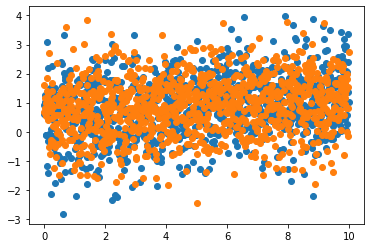

In [6]:
plt.scatter(t1,d1)
plt.scatter(t2,d2)
plt.show()

Although the signal is the same every time we run our data function, the noise is different meaning we get different answers. 

### Bayesian Inference 

First, let us assume that we know $\sigma$. This is a realistic assumptions: by taking enough data with no signal, we can determine $\sigma$ to good enough accuracy that we will assume it is known.  This isn't always true, but it simplifies how we think about measuring the signal.  

Now let us apply Baye's theorem to the parameters of our signal. Our hypothesis only about the signal, namely that for a given set of parameters the data (given the hypothesis) is of the form
$$ data(t|H)=S(t|H) + noise(t)$$ 
However, the only thing that is random is the noise, so the probability of the data is simply:
$$P(D|H) =\frac{1}{(2\pi)^{N/2} \sigma^N} e^{-(\sum_i (data(t_i) - S(t_i))^2/(2\sigma^2)}$$
This is literally just the same equation we would have for the noise, given that in our model $data_i -S_i =n_i$.  However, what is important is that as we change the signal, we change how much we need noise to account for the measured data points.

Applying this to our simulated time series. We are looking to determine the values of $a$ and $b$ form our data. First let's define the posterior for $a$, $b$ given the model

In [7]:
def Pos_line(data,a,b,t,s=1):
    noise2=((data-a*t-b)**2).sum()
    return np.exp(-noise2/(2*s**2))

To visualize what this is doing, first let us hold $b=0.5$ fixed and calculate the $P(H|D)$ just for $a$:

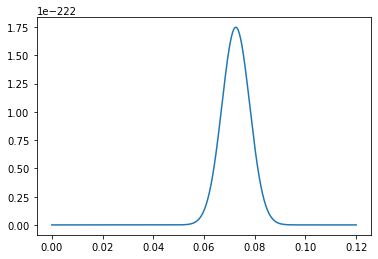

In [8]:
a_r=np.linspace(0,0.12,1000)
Pos_r=np.zeros(1000)
for i in range(1000):
    Pos_r[i]=Pos_line(d1,a_r[i],0.5,t1)
plt.plot(a_r,Pos_r)
plt.show()

We notice the very small size of the posterior here, because I didn't bother to normal by dividing by $P(D)$. In practice, we we need to know about the postior is just the maximum likelihood point and $1\sigma$, $2\sigma$, $3\sigma$ lines. However for this we don't actually need to work with the full posterior.  Instead we can take the log: 
$$-2\log P(H,D) = \sum_i (data(t_i) - S(t_i))^2/(\sigma^2) +{\rm constant} $$
We see that minimizing $-\log P(H,D)$ is exactly the same quantity we minimized in finding our best fit curves.  Now suppose that in the vacinity of the maximum likelihood point for a parameter of our model, $a$ we have
$$ -\log P(H,D) \approx \frac{(a-a_{\rm min})^2}{2 \sigma_a^2} + {\rm constant}$$
Then when $a = a_{\rm min} + n \sigma_a$ we have $-2\log P(H,D) = -2\log P(H,D)|_{a_{\rm min}}+ n^2$.

We can calculate $\chi^2 =-2\log P(H,D)$ for a given value of $a$ and $b$ as

In [9]:
def chi_line(data,a,b,t,s=1):
    noise2=((data-a*t-b)**2).sum()
    return noise2/(s**2)

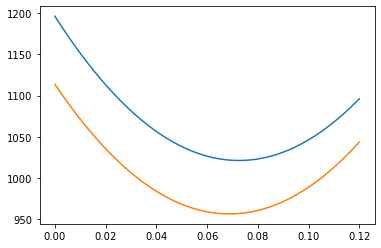

In [10]:
chi_r1=np.zeros(1000)
chi_r2=np.zeros(1000)
for i in range(1000):
    chi_r1[i]=chi_line(d1,a_r[i],0.5,t1)
    chi_r2[i]=chi_line(d2,a_r[i],0.5,t1)
plt.plot(a_r,chi_r1)
plt.plot(a_r,chi_r2)
plt.show()

Notice that our two data sets give us slightly different minima, particularly the overall $\chi^2$. For 1000 data points with $\sigma=1$, we would expect

$$\langle \chi^2 \rangle =\sum_{i=1}^N \frac{\langle n_i^2 \rangle}{\sigma^2} = N$$

The variane of $\chi^2$ can be calculated this way and is of order $\sqrt{N} \sim 30$ in this case.

The purpose of most data analyses is to estimate the parameters, in this case $a$ and $b$. First we need to find the best fit values. These are defined by the values of $a$ and $b$ that maximize likelihood $P(H|D)$ or, alternatively, give the minimum value of $\chi^2$. 

In [11]:
from scipy.optimize import minimize
from scipy.optimize import newton

Using these python libraries, we can find the maximum likelihood/minimum $\chi^2$ without too much work:

In [12]:
minimize(lambda X:chi_line(d1,X[0],X[1],t1),[0.07,0],method='Nelder-Mead',tol=1e-6)

 final_simplex: (array([[0.08618042, 0.40917881],
       [0.08618042, 0.40917938],
       [0.0861806 , 0.40917791]]), array([1019.16453445, 1019.16453445, 1019.16453445]))
           fun: 1019.1645344525683
       message: 'Optimization terminated successfully.'
          nfev: 139
           nit: 72
        status: 0
       success: True
             x: array([0.08618042, 0.40917881])

This 'x' entry here is the minimum value of $X$ where $X[0] =a$ and $X[1] =b$ (as we can see from how they appear in chi_line. We can save these values for future use:

In [13]:
line_sol=minimize(lambda X:chi_line(d1,X[0],X[1],t1),[0.07,0],method='Nelder-Mead',tol=1e-6)['x']

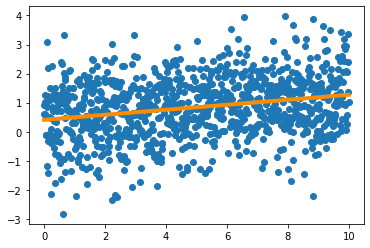

In [14]:
plt.scatter(t1,d1)
plt.plot(t1,line_sol[0]*t1+line_sol[1],lw=4,color='darkorange')
plt.show()

We need to know $\chi^2$ at the minimum so that we can find the contours associated with the 68\% and 95\% confidence regions

In [15]:
chi_min_line=chi_line(d1,line_sol[0],line_sol[1],t1)
print(chi_min_line)

1019.1645344525683


In [16]:
b_r=np.linspace(-0.5,1.5,1000)
A,B=np.meshgrid(a_r,b_r)
logP=np.zeros(A.shape)
for i in range(1000):
    for j in range(1000):
        logP[i,j]=chi_line(d1,A[i,j],B[i,j],t1)

The confidence regions are determine by surfaces of constant $\chi^2$. One way these are determined this is to take a $d$-dimensional Gaussian and find the distance for the origin corresponding to those probabilities. Of course, someone has done this for us already. So, $d=2$ (we have two parameters) we can look up that $\chi^2 = \chi_{\rm min}^2 + \Delta \chi^2$, the 68\% and 95\% correspond to $\Delta\chi^2 = 2.30$ and $6.18$ respectively.

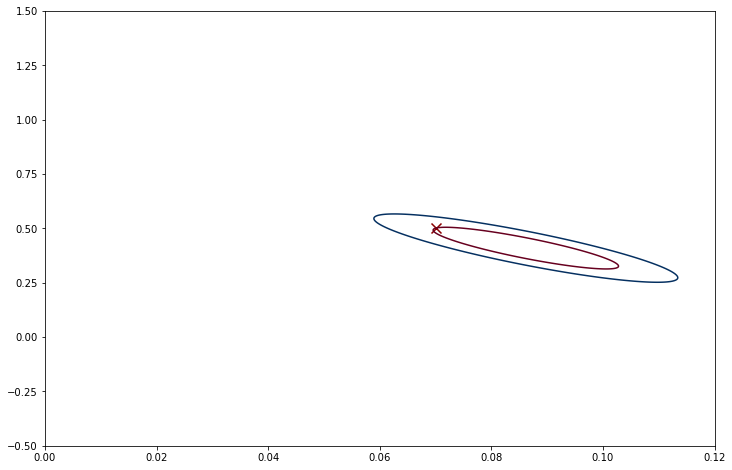

In [17]:
fig,ax=plt.subplots(figsize=(12,8))
ax.contour(A,B,logP,cmap='RdBu',levels=[chi_min_line+2.30,chi_min_line+6.18])
ax.scatter(0.07,0.5,marker='x',s=100,color='darkred')
plt.show()

### Marginalization

Let's imagine that the slope of this line is the important physical parameter. We have to measure $b$ as well, but what we really care about is $P(a|D)$. It is not correct to just fix $b=0.5$ because we don't actually know the correct value of $b$. Instead, we have to integrate over $b$ to give us a probability for $a$ alone. What we are doing is called "marginalizing over $b$"

In [18]:
def chi_marg(data,a,t,s=1):
    Mar_pos=integrate.quad(lambda x: Pos_line(data,a,x,t,s=1),0,1,epsabs=1.49e-16, epsrel=1.49e-16, limit=500)[0]
    return -2*np.log(Mar_pos)

In [19]:
chi_mar_out=np.zeros(len(a_r))
for i in range(len(a_r)):
    chi_mar_out[i]=chi_marg(d1,a_r[i],t1)

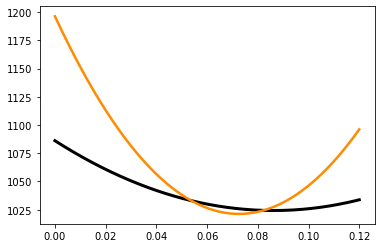

In [20]:
plt.plot(a_r,chi_mar_out,lw=3,color='black')
plt.plot(a_r,chi_r1,lw=2.5,color='darkorange')
plt.show()

Notice that the $\chi^2$ as a function of $a$ increases much more slowly when we marginalize. This is the consequence of not knowing $b$. Fixing $b$ corresponds to adding data which leads to a sharper measurement of $a$.

Now we can calculate the 1$\sigma$ and 2$\sigma$ (essentially the same as 68\% and 95\%). Now we are take a $\chi^2$ distribution with $d=1$ so the $\delta\chi^2$ are easy to calculate, they are just 1 and 4 ($1^2$ and $2^2$).

In [21]:
a_min_marg=minimize(lambda x:chi_marg(d1,x,t1),0.070,method='Nelder-Mead',tol=1e-7)['x']
chi_min_marg=chi_marg(d1,a_min_marg,t1)

In [22]:
s1L_marg=newton(lambda x:chi_marg(d1,x,t1)-chi_min_marg-1,0.05)
print(s1L_marg)
s1R_marg=newton(lambda x:chi_marg(d1,x,t1)-chi_min_marg-1,0.09)
print(s1R_marg)
s2L_marg=newton(lambda x:chi_marg(d1,x,t1)-chi_min_marg-4,0.05)
print(s2L_marg)
s2R_marg=newton(lambda x:chi_marg(d1,x,t1)-chi_min_marg-4,0.09)
print(s2R_marg)

0.07522598473781987
0.09713488478153535
0.06427152864989372
0.10808937145066398


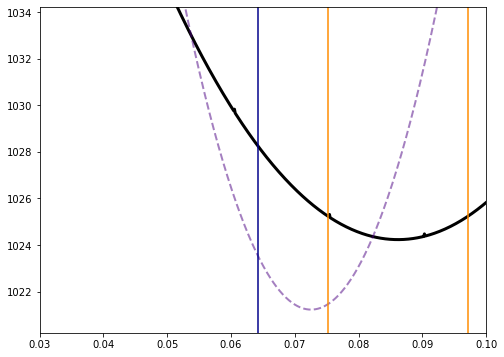

In [23]:
fig,ax=plt.subplots(figsize=(8,6))
ax.plot(a_r,chi_mar_out,lw=3,color='black')
ax.plot(a_r,chi_r1,lw=2,color='indigo',ls='--',alpha=0.5)
ax.plot(s1L_marg*np.ones(2),[chi_min_marg-4,chi_min_marg+10],color='darkorange')
ax.plot(s1R_marg*np.ones(2),[chi_min_marg-4,chi_min_marg+10],color='darkorange')
ax.plot(s2L_marg*np.ones(2),[chi_min_marg-4,chi_min_marg+10],color='darkblue')
ax.plot(s2R_marg*np.ones(2),[chi_min_marg-4,chi_min_marg+10],color='darkblue')
ax.set_xlim(0.03,0.1)
ax.set_ylim(chi_min_marg-4,chi_min_marg+10)
plt.show()

## Summary

We have seen how to implement random numbers to make simulated data. We then use this to test our methods for Bayesian inference on the simulated data. The ideas we are following here are the same principles as much more complex data analysis problems. As we will see later in the course, as the problems become more complex, the challenge is finding the minimum and the various contours which becomes more computationally expensive.